In [1]:
import sys, os
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../scripts')
root = os.getcwd()


from TwintDataMiner import TwintDataMiner
from PandasDataCleaner import PandasDataCleaner
from TextBlobSentiment import TextBlobSentiment
from Visualisation import Visualisation
from GMM import GMM


In [2]:
tweetsFile = "../data/location_tweets1.csv"
tdm = TwintDataMiner()
attributes = ["id", "tweet", "place", "date"]
df = tdm.getPandasDataFrame(attributes, tweetsFile)
pdc = PandasDataCleaner()
df.shape
df.head
df = pdc.addGeneralLocation(df)

In [3]:

# df = df.groupby('genplace')['id'].nunique()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df)

In [4]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df.loc[df['genplace'].isin(states)]

In [5]:
df = pdc.cleanTweets(df, 'tweet')
df = df.reset_index(drop=True)

In [6]:
vocab = ['conspiracy', '5g', 'broadband', 'fake', 'hoax', 'radiation', 'false', 'establishment', 'mainstream', 'media', 'poisoning', 'causes', 'brainwash', 'brainwashing', 'propaganda', 'disinformation', 'indoctrination']
gmm = GMM()
bow = gmm.generateBagOfWords(df, 'tweet', vocab=vocab)
print(bow.shape)
print(np.sum(bow))

(1538, 17)
71


In [38]:
state_bows = dict()
def returnstate(place, state):
    if(state in place):
        return True
    return False
for state in states:
    tempdf = df[df['genplace'].apply(lambda x: returnstate(x, state))].copy()
    

    tempdf.sort_values("id", inplace=True)
    
    tempdf.drop_duplicates(subset=["tweet"],inplace=True) 
    tempdf = tempdf.reset_index(drop=True)
    pdc = PandasDataCleaner()
    tempdf = pdc.cleanTweets(tempdf, 'tweet')
    
    bow = gmm.generateBagOfWords(tempdf, 'tweet', vocab=vocab)
    state_tweet_count = tempdf.shape[0]
    panicRow = np.sum(bow, axis=0)
    panicRow = np.true_divide(panicRow, state_tweet_count)
    if(state_tweet_count > 9):
        state_bows[state] = panicRow
        
        

/home/dominic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [96]:
state_index_dict = dict()

bowMatrix = np.empty((1, len(vocab)), int)

index_count = 0
for state in states:
    if(state in state_bows):
        bowMatrix = np.append(bowMatrix, np.reshape(state_bows[state], (1, len(vocab))), axis=0)
        state_index_dict[state] = index_count
        index_count += 1
        
bowMatrix = np.delete(bowMatrix, (0), axis=0)

print(bowMatrix.shape)
        

(29, 17)


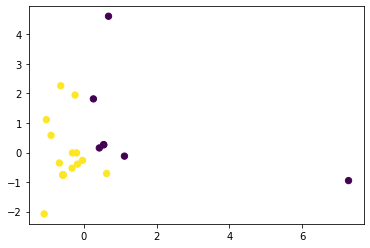

In [98]:
gmm_output = gmm.modelFromBow(bowMatrix)

In [99]:
cvalue = gmm_output[:, 0]
print(cvalue)

[1.00000000e+000 3.08469352e-041 1.00000000e+000 5.66690923e-181
 5.66690923e-181 0.00000000e+000 0.00000000e+000 0.00000000e+000
 5.66690923e-181 1.00000000e+000 5.66690923e-181 1.00000000e+000
 5.66690923e-181 6.92852550e-069 5.66690923e-181 5.66690923e-181
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 5.66690923e-181 5.66690923e-181 5.66690923e-181 1.00000000e+000
 3.29334768e-105 2.60934167e-105 1.00000000e+000 0.00000000e+000
 1.00000000e+000]


In [100]:
x = np.zeros((len(cvalue),2))
x[:, 0] = cvalue
print(x)




[[1.00000000e+000 0.00000000e+000]
 [3.08469352e-041 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [6.92852550e-069 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [5.66690923e-181 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [3.29334768e-105 0.00000000e+000]
 [2.60934167e-105 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.

In [101]:
presdf = pd.read_csv('../data/1976-2016-president.csv')
for state in state_index_dict:
    tempdf = presdf.loc[(presdf['year'] == 2016) & (presdf['state_po'] == state) & (presdf['candidate'] == 'Trump, Donald J.')]
    voteshare = (tempdf['candidatevotes'].iloc[0] / tempdf['totalvotes'].iloc[0]) * 100
    x[state_index_dict[state], 1] = voteshare

print(x)

[[1.00000000e+000 6.20830924e+001]
 [3.08469352e-041 4.86716165e+001]
 [1.00000000e+000 3.16171065e+001]
 [5.66690923e-181 4.32513974e+001]
 [5.66690923e-181 4.09269144e+001]
 [0.00000000e+000 4.07038311e+000]
 [0.00000000e+000 4.90219414e+001]
 [0.00000000e+000 5.07713261e+001]
 [5.66690923e-181 3.87617531e+001]
 [1.00000000e+000 5.69400334e+001]
 [5.66690923e-181 5.80886847e+001]
 [1.00000000e+000 3.39093047e+001]
 [5.66690923e-181 3.22862028e+001]
 [6.92852550e-069 4.74975642e+001]
 [5.66690923e-181 4.49251931e+001]
 [5.66690923e-181 5.67723478e+001]
 [0.00000000e+000 4.13503867e+001]
 [0.00000000e+000 3.23906023e+001]
 [0.00000000e+000 4.98280947e+001]
 [0.00000000e+000 5.16876507e+001]
 [5.66690923e-181 6.53228648e+001]
 [5.66690923e-181 4.85778858e+001]
 [5.66690923e-181 3.88980575e+001]
 [1.00000000e+000 5.49393327e+001]
 [3.29334768e-105 6.07220337e+001]
 [2.60934167e-105 5.22346856e+001]
 [1.00000000e+000 4.44276470e+001]
 [0.00000000e+000 3.68326802e+001]
 [1.00000000e+000 4.

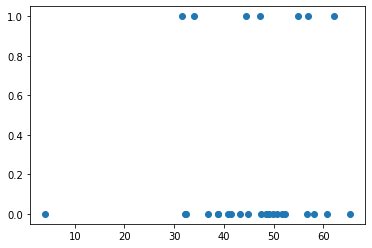

In [102]:

y = x[:, 0]
z = x[:, 1]
plt.scatter(z, y)
plt.show()